In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import fbeta_score
from sklearn.metrics import log_loss

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit


import seaborn as sns

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, ELU, Add
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator

from sys import platform
from sklearn import preprocessing
import os

from multiprocessing import Pool, cpu_count
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import fbeta_score
from PIL import Image, ImageStat
import pandas as pd
import numpy as np
import glob, cv2

from scipy.stats import kurtosis, skew
from scipy.ndimage import laplace, sobel

from random import choice

from numpy import matrix
from numpy import linalg
import math


In [85]:
if platform == "linux":
    dataDir = "/home/donchan/Documents/myData/KaggleData/Iceberg"
else:
    dataDir = "/Users/donchan/Documents/myData/KaggleData/Iceberg"
train_data = os.path.join(dataDir,"data/processed/train.json")
test_data = os.path.join(dataDir,"data/processed/test.json")

print("load data...")


train = pd.read_json(train_data)
test = pd.read_json(test_data)
#train.inc_angle = train.inc_angle.replace('na', 0)
#train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("done!")

angle = train.inc_angle.copy()
angle = angle.replace('na',np.nan)

angle_median = angle.median()
angle_mean = angle.mean()
angle = angle.astype(np.float32).fillna(angle_median)

test_angle = test.inc_angle.copy()
test_angle = test_angle.replace('na',np.nan)

test_angle_median = test_angle.median()
test_angle_mean = test_angle.mean()
test_angle = test_angle.astype(np.float32).fillna(test_angle_median)





load data...
done!


In [67]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)


In [68]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [69]:
def rescale(imgs): 
    return imgs / 100. +  0.5


In [71]:
X_train_rescale = rescale(X_train)
X_test_rescale = rescale(X_test)

# loading data #

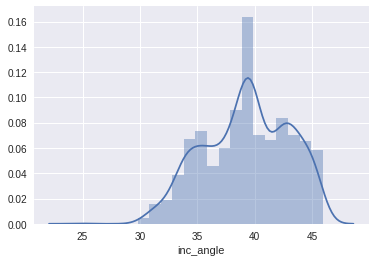

In [78]:
sns.distplot(angle)

In [57]:
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

x1_shape = x_band1.shape
x2_shape = x_band2.shape

scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()
stand_x_band1 = mm_scaler.fit_transform(x_band1.reshape(-1,1))
stand_x_band2 = mm_scaler.fit_transform(x_band2.reshape(-1,1))
x_band1_st = stand_x_band1.reshape(x1_shape)
x_band2_st = stand_x_band2.reshape(x2_shape)


In [58]:
x_band1.shape,x_band2.shape,x_band1_st.shape,x_band2_st.shape

((1604, 75, 75), (1604, 75, 75), (1604, 75, 75), (1604, 75, 75))

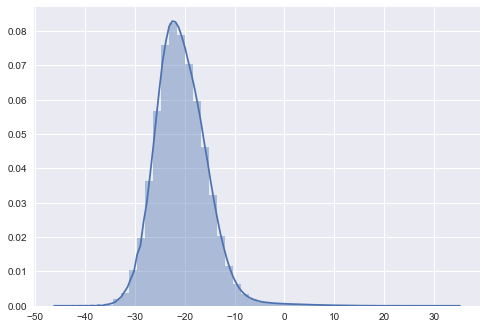

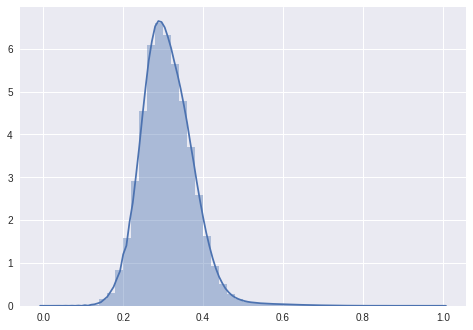

In [14]:
sns.distplot(stand_x_band1)

In [59]:
X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])


#X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
#                          , X_band_2[:, :, :, np.newaxis]
#                         , X_band_3[:, :, :, np.newaxis]], axis=-1)


In [60]:
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])

x1_shape = x_band1.shape
x2_shape = x_band2.shape

scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()
stand_x_band1 = mm_scaler.fit_transform(x_band1.reshape(-1,1))
stand_x_band2 = mm_scaler.fit_transform(x_band2.reshape(-1,1))
x_band1_st = stand_x_band1.reshape(x1_shape)
x_band2_st = stand_x_band2.reshape(x2_shape)
print(x_band1_st.shape,x_band2_st.shape)

(8424, 75, 75) (8424, 75, 75)


In [61]:
X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1 + x_band1)/2)[:, :, :, np.newaxis]], axis=-1)

print(X_test.shape)

(8424, 75, 75, 3)


# check shape of X_train X_angle_train y_train #

In [14]:
X_train.shape,X_angle_train.shape,y_train.shape

((1604, 75, 75, 3), (1604,), (1604,))

# load Full Layer vgg16 #

In [3]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)


553459712/553467096 [============================>.] - ETA: 0s

# loading VGG 16 model to eliminate Fc layer # 

In [6]:
model = VGG16(weights='imagenet', include_top=False)
print('Model loaded.')


58875904/58889256 [============================>.] - ETA: 0sModel loaded.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [9]:
model.output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(512)])

## outout layer should be 4 x 4 x 512, but it does not show shape information because of input image is missing ? ## 

In [100]:
def get_model():
    
    input_meta = Input(shape=[1], name='angle')
    #input_meta_bn = BatchNormalization(momentum=bn_model)(input_meta)
    
    
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    
    base_model.load_weights("../vgg16_weights.h5")


    x = base_model.get_layer('block5_pool').output
    #print("",x)
    x = GlobalMaxPooling2D()(x)
    #print("top_cnn shape after Global MaxPooling", top_cnn.shape)

    dense_layer= Dense(256, activation='relu', name='fc2')(x)
    dense_layer = Dropout(0.2)(dense_layer)  # drop out 0 - 0.5
    predictions = Dense(1, activation='sigmoid')(dense_layer)

    #model = Model(input=base_model.input, output=predictions)
    model = Model(input=[base_model.input, input_meta], output=predictions)

    for i, layer in enumerate(model.layers[:18]):
        if layer.trainable:
            print(layer.name)
            print("layer trainable %d : True -> False" % i)
            layer.trainable = False
    
    
    
    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])
    return model

In [ ]:
model = get_model()

KeyError: "Can't open attribute (Can't locate attribute: 'layer_names')"

In [88]:
for i, layer in enumerate(model.layers[:25]):
    print(i, layer.trainable)


0 False
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True


In [39]:
base_model.output.shape

TensorShape([Dimension(None), Dimension(2), Dimension(2), Dimension(512)])

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

# Restore last layer block5_pool #

In [21]:
x = base_model.get_layer('block5_pool').output
print(x)

Tensor("block5_pool_2/MaxPool:0", shape=(?, 2, 2, 512), dtype=float32)


In [25]:


x = GlobalMaxPooling2D()(x)
print("top_cnn shape after Global MaxPooling", top_cnn.shape)

#I tried fine-tuned with resnet50 as well, 
#but like William said, these images are quite different ... 
#What I've tried is to resize the image and fine-tune the last fc layers 
#and add one more fc layer to train, 
#in which the pre-trained model is helpful 
#but not useful (acc~70%, loss > .6, too bad...). 
#Maybe try to fine tune to from more later bottleneck layer(s) can have much performance boost (I did not try it)


#Actually In my opinion, 
#we can use pretrained model. 
#However, the things we need to fine-tune should be whole network, 
#which means all the pretrained weight we got is just initial parameter for this problem, 
#the goal is to easier find global minimum. 
#However, you definitely can modify the models based on your own deep learning knowledge. 
#I made some experiments and found modified pretrained model is better than some simple CNN model.


dense_layer= Dense(256, activation='relu', name='fc2')(x)
dense_layer = Dropout(0.2)(dense_layer)  # drop out 0 - 0.5
predictions = Dense(1, activation='sigmoid')(dense_layer)

model = Model(input=base_model.input, output=predictions)

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


#dense_ayer = ELU()(BatchNormalization(momentum=bn_model)( Dense(512, activation=None)(top_cnn) ))
#dense_ayer = Dropout(0.5)(dense_ayer)
#dense_ayer = ELU()(BatchNormalization(momentum=bn_model)( Dense(256, activation=None)(dense_ayer) ))
#dense_ayer = Dropout(0.5)(dense_ayer)

# 2 for One Hot code for Binary 
#output = Dense(2, activation="softmax")(dense_ayer)



#model = Model([input_1],  output)


top_cnn shape after Global MaxPooling (?, 512)


/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


# implement last layer (after block5) #

# Callbacks #

In [82]:
def get_callbacks(filepath, patience=10):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]



In [98]:
def myBaseCrossTrain(X_train, target_train):
    
    K = 4
    folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
    y_test_pred_log = 0
    y_valid_pred_log = 0.0*target_train
    for j, (train_idx, test_idx) in enumerate(folds):
        #file_path = "%s_model_weights.hdf5"%j
        #os.remove(file_path)
        #callbacks = get_callbacks(filepath=file_path, patience=5)
        
        print('\n===================FOLD=',j+1)
        X_train_cv = X_train[train_idx]
        y_train_cv = target_train[train_idx]
        X_holdout = X_train[test_idx]
        Y_holdout= target_train[test_idx]
        
        angle_meta_cv = angle[train_idx]
        angle_meta_holdout = angle[test_idx]
        
        
        file_path = "keras_vgg16_model3_weights_%s.hdf5" % j
        callbacks = get_callbacks(filepath=file_path, patience=10)

        
        #galaxyModel=getVggModel()
        galaxyModel=get_model()

        galaxyModel.fit([X_train_cv, angle_meta_cv ], y_train_cv,
                  batch_size=24,
                  epochs=80,
                  verbose=1,
                  validation_data=([X_holdout, angle_meta_holdout ], Y_holdout),
                  callbacks=callbacks)

        #Getting the Best Model
        galaxyModel.load_weights(filepath=file_path)

        #Getting Training Score
        score = galaxyModel.evaluate([X_train_cv, angle_meta_cv ], y_train_cv, verbose=0)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        #Getting Test Score
        score = galaxyModel.evaluate([X_holdout, angle_meta_holdout], Y_holdout, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        #Getting validation Score.
        pred_valid=galaxyModel.predict([X_holdout, angle_meta_holdout ] )
        y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores
        temp_test=galaxyModel.predict([X_test, test_angle])
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    y_test_pred_log=y_test_pred_log/K

    print('\nLog Loss Validation= ',log_loss(target_train, y_valid_pred_log))
    return y_test_pred_log

In [99]:
test_results = myBaseCrossTrain(X_train,y_train)


===================FOLD= 1


/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


block1_conv1
layer trainable 1 : True -> False
block1_conv2
layer trainable 2 : True -> False
block1_pool
layer trainable 3 : True -> False
block2_conv1
layer trainable 4 : True -> False
block2_conv2
layer trainable 5 : True -> False
block2_pool
layer trainable 6 : True -> False
block3_conv1
layer trainable 7 : True -> False
block3_conv2
layer trainable 8 : True -> False
block3_conv3
layer trainable 9 : True -> False
block3_pool
layer trainable 10 : True -> False
block4_conv1
layer trainable 11 : True -> False
block4_conv2
layer trainable 12 : True -> False
block4_conv3
layer trainable 13 : True -> False
block4_pool
layer trainable 14 : True -> False
block5_conv1
layer trainable 15 : True -> False
block5_conv2
layer trainable 16 : True -> False
block5_conv3
layer trainable 17 : True -> False
Train on 1202 samples, validate on 402 samples
Epoch 1/80
1202/1202 [==============================] - 3s - loss: 0.8105 - acc: 0.5158 - val_loss: 0.6892 - val_acc: 0.5522
Epoch 2/80
1202/1202 [===

KeyboardInterrupt: 

# make submission file #

In [48]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': test_results})

In [49]:
submission.head()

,id,is_iceberg
0,5941774d,0.075891
1,4023181e,0.389140
2,b20200e4,0.004431
3,e7f018bb,0.998434
4,4371c8c3,0.047113


In [50]:
submission.to_csv("output/keras_vgg16_model3.csv",index=False)

In [16]:
np.corrcoef(X_angle_train,y_train)

array([[ 1.        ,  0.26628294],
       [ 0.26628294,  1.        ]])

# One hot code y_train #

In [29]:
oh = preprocessing.OneHotEncoder(sparse=False)
y_train_oh = oh.fit_transform( y_train[:,np.newaxis])


In [30]:
y_train_oh[:10]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [31]:
y_train[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [38]:
np.arange(12).reshape(3,4).mean(axis=1)

array([ 1.5,  5.5,  9.5])

# Split Training and Validation #

In [18]:
x_train, x_valid, y_train_oh, y_valid_oh = train_test_split(X_train, y_train_oh, test_size=0.2, random_state=42)

In [19]:
x_train.shape, x_valid.shape, y_train_oh.shape, y_valid_oh.shape

((1283, 75, 75, 3), (321, 75, 75, 3), (1283, 2), (321, 2))

In [20]:
train["is_iceberg"].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

# Keras Model Definiton #

In [45]:
def get_model(p_activation="elu", k_size = (5,5), dropout=0.25):
    bn_model = 0.99
    #p_activation = "elu"
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(32, kernel_size = k_size, activation=p_activation, padding="same") ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(32, kernel_size = k_size, activation=p_activation, padding="same") (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(dropout)(img_1)

    img_1 = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_1))
    img_1 = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")(img_1)
    img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = Dropout(dropout)(img_1)    
    
    print("img1 shape", img_1.shape)

    img_resid = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_1))
    img_resid = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")(img_resid)
    img_resid = Dropout(dropout)(img_resid)    
    print("img_resid shape1", img_resid.shape)
    
    img_resid = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(img_resid))
    img_resid = Conv2D(64, kernel_size = k_size, activation=p_activation, padding="same")(img_resid)
    print("img_resid shape2", img_resid.shape)

    cnn_resid_added = Add()([img_1, img_resid])
    print("cnn_resid shape", cnn_resid_added.shape)
    
    top_cnn = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(cnn_resid_added))
    top_cnn = Conv2D(128, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    top_cnn = Conv2D(256, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(top_cnn))
    top_cnn = Conv2D(256, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = Dropout(0.25)(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    top_cnn = Conv2D(512, kernel_size = k_size, activation=p_activation, padding="same")((BatchNormalization(momentum=bn_model))(top_cnn))
    top_cnn = Conv2D(512, kernel_size = k_size, activation=p_activation, padding="same")(top_cnn)
    top_cnn = Dropout(dropout)(top_cnn)
    top_cnn = MaxPooling2D((2,2)) (top_cnn)
    
    top_cnn = GlobalMaxPooling2D()(top_cnn)
    print("top_cnn shape", top_cnn.shape)

    dense_ayer = ELU()(BatchNormalization(momentum=bn_model)( Dense(512, activation=None)(top_cnn) ))
    dense_ayer = Dropout(0.5)(dense_ayer)
    dense_ayer = ELU()(BatchNormalization(momentum=bn_model)( Dense(256, activation=None)(dense_ayer) ))
    dense_ayer = Dropout(0.5)(dense_ayer)
    
    # 2 for One Hot code for Binary 
    output = Dense(2, activation="softmax")(dense_ayer)
    
    
    
    model = Model([input_1],  output)
    #optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    optimizer = Adam(lr=0.001)
    
    #model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    #model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy"])
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    
    return model


In [51]:
model = get_model(dropout=0.5,k_size=(3,3))
model.summary()

img1 shape (?, 18, 18, 64)
img_resid shape1 (?, 18, 18, 128)
img_resid shape2 (?, 18, 18, 64)
cnn_resid shape (?, 18, 18, 64)
top_cnn shape (?, 512)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
X_1 (InputLayer)                 (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_658 (BatchNo (None, 75, 75, 3)     12          X_1[0][0]                        
____________________________________________________________________________________________________
conv2d_1023 (Conv2D)             (None, 75, 75, 32)    896         batch_normalization_658[0][0]    
____________________________________________________________________________________________________
conv2d_1024 (Conv2D)             (None, 75,

# training parameters #

In [55]:
batch_size = 32
epochs = 50 ## change this to 80
#steps_per_epoch=np.power(2,14) /batch_size ## change to 2^14

#print(steps_per_epoch)

# Callback definition #

In [56]:
def get_callbacks(filepath, patience=10):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = "keras_model2_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)



In [57]:
gen_images = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,)
        #fill_mode='nearest')

model.fit_generator(
    
        gen_images.flow(x_train,y_train_oh,batch_size=batch_size),
        steps_per_epoch=np.ceil(32.0 * float(y_train_oh.shape[0]) / float(batch_size)),
        epochs=epochs,
        validation_data=(x_valid,y_valid_oh),
        validation_steps=np.ceil(32.0 * float(y_valid_oh.shape[0]) / float(batch_size)), 
        callbacks=callbacks)

Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[32,75,75,32]
	 [[Node: conv2d_1023/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](batch_normalization_658/cond/Merge, conv2d_1023/kernel/read)]]
	 [[Node: loss_73/mul/_21137 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_7073_loss_73/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_1023/convolution', defined at:
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-cea55d126f84>", line 1, in <module>
    model = get_model(dropout=0.5,k_size=(3,3))
  File "<ipython-input-45-86bf7e30ed38>", line 7, in get_model
    img_1 = Conv2D(32, kernel_size = k_size, activation=p_activation, padding="same") ((BatchNormalization(momentum=bn_model))(input_1))
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3164, in conv2d
    data_format='NHWC')
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 672, in convolution
    op=op)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 664, in op
    name=name)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/donchan/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,75,75,32]
	 [[Node: conv2d_1023/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](batch_normalization_658/cond/Merge, conv2d_1023/kernel/read)]]
	 [[Node: loss_73/mul/_21137 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_7073_loss_73/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [27]:
model.load_weights(filepath=file_path)
score = model.evaluate(x_valid, y_valid_oh, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


320/321 [============================>.] - ETA: 0sTest loss: 0.26210459931
Test accuracy: 0.890965732087


In [40]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)







#x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
#x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
#                          , x_band2[:, :, :, np.newaxis]
#                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)


In [50]:
prediction = model.predict([X_test], verbose=1, batch_size=200)

8400/8424 [============================>.] - ETA: 0s

In [53]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction[:,1]})

In [54]:
submission.head()

,id,is_iceberg
0,5941774d,0.695578
1,4023181e,0.113909
2,b20200e4,0.000026
3,e7f018bb,0.966803
4,4371c8c3,0.020416


In [55]:
submission.to_csv("output/keras_model2_basic.csv",index=False)

# test for Cross Validation #

In [35]:
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


In [32]:
y_onehot = np_utils.to_categorical( y_train )
num_classes = y_onehot.shape[1]

In [47]:
p_activation = ["elu","relu", "sigmoid"]
k_size = [(3,3), (5,5)]
dropout = [0.25, 0.50, 0.75 ]
nb_epoch = [10, 25, 50]
batch_size = [16, 32, 64]


In [49]:
model = KerasClassifier(build_fn=get_model, verbose=1)
param_grid = dict(p_activation=p_activation, 
                  k_size=k_size, 
                  dropout=dropout, 
                  nb_epoch=nb_epoch, 
                  batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid)


In [ ]:


input_CNN = input_img_norm %>%
    layer_conv_2d(32, kernel_size = kernel_size,padding = "same") %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_max_pooling_2d(c(2,2)) %>%
    layer_dropout(0.25) %>%
    layer_conv_2d(64, kernel_size = kernel_size,padding = "same") %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_max_pooling_2d(c(2,2)) %>%
    layer_dropout(0.25) 

## first residual
input_CNN_residual = input_CNN %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_conv_2d(128, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_conv_2d(64, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu()

input_CNN_residual = layer_add(list(input_CNN_residual,input_CNN))

top_CNN = input_CNN_residual %>%
  layer_conv_2d(128, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_conv_2d(256, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_conv_2d(512, kernel_size = kernel_size,padding = "same") %>%
  layer_batch_normalization(momentum = 0.99) %>%
  layer_activation_elu() %>%
  layer_dropout(0.25) %>%
  layer_max_pooling_2d(c(2,2)) %>%
  layer_global_max_pooling_2d()

outputs = top_CNN %>%
    layer_dense(512,activation = NULL) %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_dropout(0.5) %>%
    layer_dense(256,activation = NULL) %>%
    layer_batch_normalization(momentum = 0.99) %>%
    layer_activation_elu() %>%
    layer_dropout(0.5) %>%
    layer_dense(2,activation = "softmax") ## not sure using softmax is the right thing to do...
    
model <- keras_model(inputs = list(input_img), outputs = list(outputs))

model %>% compile(optimizer=optimizer_adam(lr = 0.001),
                  loss="binary_crossentropy",
                  metrics = c("accuracy"))

summary(model)